In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd
import gdn_datacollector
import gdn_db
from googleads import adwords

In [2]:

sizepop, vardim, MAXGEN, params = 1000, 3, 15, [0.9, 0.5, 0.5]
# sizepop, vardim, MAXGEN, params = 1000, 3, 10, [0.9, 0.5, 0.5]
BIDDING_INDEX = {
    'cpc': 'cpc_bid',
    'cpa': 'cpa_bid',
}
TARGET_INDEX = {
    'cpc': 'clicks',
    'cpa': 'conversions',
}
CRITERIA_LIST = ['ADGROUP', 'URL', 'CRITERIA', 'AGE_RANGE', 'DISPLAY_KEYWORD', 'AUDIENCE']
DATABASE_INDEX = {
    'ADGROUP': 'adgroup_insights',
    'URL': 'url_insights',
    'CRITERIA': 'criteria_insights',
    'AUDIENCE': 'audience_insights',
    'AGE_RANGE': 'age_range_insights',
    'DISPLAY_KEYWORD': 'display_keyword_insights',
}
SCORE_INDEX = {
    'ADGROUP': 'adgroup',
    'URL': 'url',
    'CRITERIA': 'criteria',
    'AUDIENCE': 'audience',
    'AGE_RANGE': 'age_range',
    'DISPLAY_KEYWORD': 'display_keyword',
}
SCORE_COLUMN_INDEX = {
    'ADGROUP': ['campaign_id', 'adgroup_id', 'score'],
    'URL': ['campaign_id', 'url_display_name', 'score'],
    'CRITERIA': ['campaign_id', 'keyword_placement', 'keyword_id', 'score'],
    'AUDIENCE': ['campaign_id', 'audience', 'criterion_id', 'score'],
    'AGE_RANGE': ['campaign_id', 'age_range', 'criterion_id', 'score'],
    'DISPLAY_KEYWORD': ['campaign_id', 'keyword', 'keyword_id', 'score'],
}

In [3]:
AUTH_FILE_PATH = '/home/tim_su/ai_optimizer/opt/ai_optimizer/googleads.yaml'
adwords_client = adwords.AdWordsClient.LoadFromStorage(AUTH_FILE_PATH)

def retrive_all_criteria_insights(campaign_id=None):
    if campaign_id:
        df = gdn_db.get_campaign(campaign_id)
        customer_id = df['customer_id'].iloc[0]
        destination_type = df['destination_type'].iloc[0]
        adwords_client.SetClientCustomerId(customer_id)
        camp = gdn_datacollector.Campaign(customer_id, campaign_id, destination_type)
        for criteria in CRITERIA_LIST:
            camp.get_performance_insights( performance_type=criteria, date_preset='YESTERDAY' )
        return
    df_camp = gdn_db.get_campaign()
    campaign_id_list = df_camp['campaign_id'].unique()
    # retrive all criteria insights
    for campaign_id in campaign_id_list:
        customer_id = df_camp['customer_id'][df_camp.campaign_id==campaign_id].iloc[0]
        destination_type = df_camp['destination_type'][df_camp.campaign_id==campaign_id].iloc[0]
        adwords_client.SetClientCustomerId(customer_id)
        camp = gdn_datacollector.Campaign(customer_id, campaign_id, destination_type)
        for criteria in CRITERIA_LIST:
            camp.get_performance_insights( performance_type=criteria )

In [4]:
def get_criteria_score( campaign_id=None, criteria=None):
    mydb = gdn_db.connectDB("dev_gdn")
    df = pd.DataFrame({'adgroup_id': [], 'target': [],
                       'impressions': [], 'bid_amount': []})
    df_camp = pd.read_sql(
        "SELECT * FROM campaign_target WHERE campaign_id='{}'".format(campaign_id), con=mydb)    
    table = DATABASE_INDEX[criteria]
    df = pd.read_sql(
        "SELECT * FROM {} WHERE campaign_id='{}'".format(table, campaign_id), con=mydb)
    df_weight = pd.read_sql(
        "SELECT * FROM optimal_weight WHERE campaign_id='{}' ".format(campaign_id), con=mydb)
    if not df.empty:
        if criteria != "URL" and criteria != "CRITERIA":
            df['daily_budget'] = df_camp['daily_budget'].iloc[0]
            df['bid_amount'] = df[ BIDDING_INDEX[ df['bidding_type'].iloc[0] ] ]
            df['target'] = df[ TARGET_INDEX[ df['bidding_type'].iloc[0] ] ]
            daily_destination = df_camp['destination'] / df_camp['period']
            df['daily_destination'] = daily_destination.iloc[0]
            for index, row in df.iterrows():
                df = pd.DataFrame(data=[row], columns=df.columns, index=[0])
                r = ObjectiveFunc.adgroup_fitness(df_weight, df)
                df['score'] = r
                df_final = df[ SCORE_COLUMN_INDEX[criteria] ]
                gdn_db.into_table(df_final, table=SCORE_INDEX[criteria]+"_score")   
    mydb.close()
    return 

In [5]:

class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''

    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculate_fitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selection_operation()
            self.crossover_operation()
            self.mutation_operation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print("Optimal solution is:")
        print(self.best.chrom)
        self.print_result()
        return self.best.chrom

    def selection_operation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossover_operation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutation_operation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def print_result(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()


class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''

    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]

    def calculate_fitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitnessfunc(self.chrom, df)


class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''

    def __init__(self):
        self.DATABASE = 'dev_gdn'
        self.mydb = gdn_db.connectDB(self.DATABASE)
        self.AUTH_FILE_PATH = '/home/tim_su/ai_optimizer/opt/ai_optimizer/googleads.yaml'
        self.client = adwords.AdWordsClient.LoadFromStorage(
            self.AUTH_FILE_PATH)

    def fitnessfunc(optimal_weight, df):
        m_kpi = ( df['campaign_target'] / df['daily_destination'] ).apply(np.tanh)#0.8
        m_spend = ( (df['budget_per_day'] - df['spend']) / df['budget_per_day'] ).apply(np.exp) #0.112
        m_bid = ( (df['campaign_bid'] - df['campaign_cpc']) / df['campaign_bid'] ).apply(np.exp) #-0.29

        status = np.array([m_kpi, m_spend, m_bid])
#         print(df['campaign_bid'].iloc[0], df['campaign_cpc'].iloc[0], df['campaign_bid'].iloc[0])
#         status  = np.array( [m_kpi, m_spend, m_bid, m_width] )
        r = np.dot(optimal_weight, status)
        return r

    def adgroup_fitness(optimal_weight, df):
        m_kpi = ( df['target'] / df['daily_destination'] ).apply(np.tanh) * 10
        if df['target'].iloc[0] == 0:
            m_kpi = -10
        m_spend = ( (df['daily_budget'] - df['spend']) / df['daily_budget'] ).apply(np.exp)
        m_bid = ((df['bid_amount'] - df['cost_per_target']) / df['bid_amount']).apply(np.exp)
        status = np.array([m_kpi, m_spend, m_bid])
        optimal_weight = np.array([
            optimal_weight['weight_kpi'].iloc[0],
            optimal_weight['weight_spend'].iloc[0],
            optimal_weight['weight_bid'].iloc[0]
        ])
        r = np.dot(optimal_weight, status)
#         print(status)
#         print(optimal_weight)
        return r

    def campaign_status(self, campaign_id):
        df_camp = pd.read_sql(
            "SELECT * FROM campaign_target WHERE campaign_id=%s" % (campaign_id), con=self.mydb)

        daily_destination = (df_camp['destination']/df_camp['period']).iloc[0]
        campaign_bid = (df_camp['daily_budget'] /
                        (df_camp['destination']/df_camp['period'])).iloc[0]
        daily_budget = df_camp['daily_budget'].iloc[0]
        spend = df_camp['spend'].iloc[0]
        campaign_cpc = df_camp['cost_per_target'].iloc[0]
        campaign_target = df_camp['target'].iloc[0]
        impressions = df_camp['impressions'].iloc[0]
        df = pd.DataFrame(
            {
                'campaign_id': [campaign_id],
                'campaign_cpc': [campaign_cpc],
                'campaign_target': [campaign_target],
                'impressions': [impressions],
                'campaign_bid': [campaign_bid],
                'spend': [spend],
                'daily_budget': [daily_budget],
                'daily_destination': [daily_destination],
                'budget_per_day': [daily_budget]
            }
        )
        df = df.convert_objects(convert_numeric=True)
        self.mydb.close()
        return df

    def adgroup_status(self, adgroup_id):
        df = pd.DataFrame({'adgroup_id': [], 'target': [],
                           'impressions': [], 'bid_amount': []})
        df_adgroup = pd.read_sql(
            "SELECT * FROM adgroup_insights WHERE adgroup_id=%s ORDER BY request_time DESC LIMIT 1" % (adgroup_id), con=self.mydb)
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %
                              (df_adgroup['campaign_id'].iloc[0]), con=self.mydb)
        df_adgroup['daily_budget'] = df_camp['daily_budget']
        df_adgroup['bid_amount'] = df_adgroup[ BIDDING_INDEX[df_adgroup['bidding_type'].iloc[0]] ]
        df_adgroup['target'] = df_adgroup[ TARGET_INDEX[df_adgroup['bidding_type'].iloc[0]] ]
        df_camp['daily_destination'] = df_camp['destination'] / df_camp['period']
        df_temp = pd.merge(
            df_adgroup[['campaign_id', 'adgroup_id', 'daily_budget', 'impressions']],
            df_adgroup[['adgroup_id', 'spend', 'bid_amount',
                        'target', 'cost_per_target']], on=['adgroup_id']
        )
        df_status = pd.merge(
            df_temp,
            df_camp[['campaign_id', 'daily_destination']], on=['campaign_id']
        )
#         df_status = df_temp
        df = pd.concat([df, df_status], ignore_index=True, sort=True)
        self.mydb.close()
        return df


def ga_optimal_weight(campaign_id):
    request_time = datetime.datetime.now().date()
    mydb = gdn_db.connectDB("dev_gdn")
    df_weight = pd.read_sql(
        "SELECT * FROM optimal_weight WHERE campaign_id=%s " % (campaign_id), con=mydb)
    df_camp = pd.read_sql(
        "SELECT * FROM campaign_target WHERE campaign_id=%s " % (campaign_id), con=mydb)
    df_adgroup = pd.read_sql(
        "SELECT * FROM adgroup_initial_bid WHERE campaign_id=%s " % (campaign_id), con=mydb)
    destination_type = df_camp['destination_type'].iloc[0]
    adgroup_list = df_adgroup['adgroup_id'].unique()
    for adgroup_id in adgroup_list:

        df = ObjectiveFunc().adgroup_status(adgroup_id)
        r = ObjectiveFunc.adgroup_fitness(df_weight, df)

        df_final = pd.DataFrame({'campaign_id': campaign_id, 'adgroup_id': adgroup_id,
                                 'score': r, 'request_time': request_time}, index=[0])
        print(adgroup_id, df_final['score'].iloc[0])
        gdn_db.into_table(df_final, table="adgroup_score")

    mydb.close()
    return

[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
[gdn_datacollector.Campaign.get_performance_insights] 0
campaign_id: 1837973427


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:261: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: -0.303036; average function value is 0.362035
Generation 1: optimal function value is: 1.434793; average function value is 0.851295
Generation 2: optimal function value is: 1.434793; average function value is 0.938548
Generation 3: optimal function value is: 1.446353; average function value is 0.985720
Generation 4: optimal function value is: 1.448766; average function value is 1.023367
Generation 5: optimal function value is: 1.454848; average function value is 1.067946
Generation 6: optimal function value is: 1.454848; average function value is 1.089173
Generation 7: optimal function value is: 1.454848; average function value is 1.111069
Generation 8: optimal function value is: 1.454848; average function value is 1.114136
Generation 9: optimal function value is: 1.454848; average function value is 1.110247
Generation 10: optimal function value is: 1.454848; average function value is 1.112882
Generation 11: optimal function value is: 1.454848; 

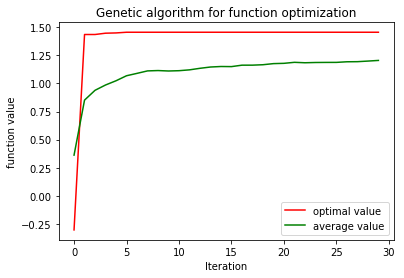

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.997022       0.94089    0.992597   1837973427  1.454848
optimal_weight: [0.99702152 0.94089041 0.99259726]
0:06:18.001957
campaign_id: 1837975386
Generation 0: optimal function value is: -0.003738; average function value is 0.959106
Generation 1: optimal function value is: 1.004823; average function value is 0.651864
Generation 2: optimal function value is: 1.004823; average function value is 0.717508
Generation 3: optimal function value is: 1.004823; average function value is 0.761822
Generation 4: optimal function value is: 1.004823; average function value is 0.798274
Generation 5: optimal function value is: 1.005294; average function value is 0.826959
Generation 6: optimal function value is: 1.005294; average function value is 0.836026
Generation 7: optimal function value is: 1.005294; average function value is 0.856158
Generation 8: optimal function value is: 1.005503; average function value is 0.860903
Generatio

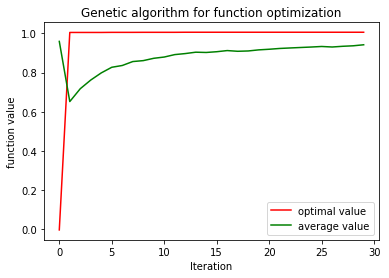

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.999899      0.651332    0.925356   1837975386  1.005863
optimal_weight: [0.9998987  0.65133235 0.92535639]
0:11:08.100212
campaign_id: 1837420283
Generation 0: optimal function value is: -0.210416; average function value is 0.554192
Generation 1: optimal function value is: 1.270823; average function value is 0.764653
Generation 2: optimal function value is: 1.270823; average function value is 0.834984
Generation 3: optimal function value is: 1.270823; average function value is 0.876007
Generation 4: optimal function value is: 1.270823; average function value is 0.916021
Generation 5: optimal function value is: 1.270823; average function value is 0.936616
Generation 6: optimal function value is: 1.272312; average function value is 0.956871
Generation 7: optimal function value is: 1.272312; average function value is 0.982859
Generation 8: optimal function value is: 1.272312; average function value is 0.987660
Generatio

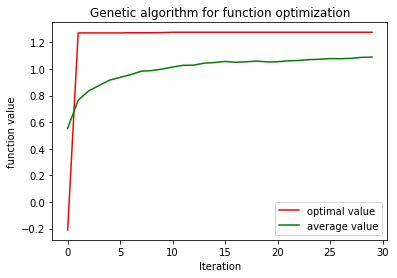

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.995198      0.701476    0.994018   1837420283  1.275913
optimal_weight: [0.99519757 0.70147607 0.994018  ]
0:15:27.575502
campaign_id: 1837064056
Generation 0: optimal function value is: -0.560591; average function value is -0.128971
Generation 1: optimal function value is: 2.275783; average function value is 1.314280
Generation 2: optimal function value is: 2.275783; average function value is 1.423433
Generation 3: optimal function value is: 2.275783; average function value is 1.494112
Generation 4: optimal function value is: 2.275783; average function value is 1.545559
Generation 5: optimal function value is: 2.275783; average function value is 1.588835
Generation 6: optimal function value is: 2.275783; average function value is 1.613738
Generation 7: optimal function value is: 2.275783; average function value is 1.630114
Generation 8: optimal function value is: 2.275783; average function value is 1.660368
Generati

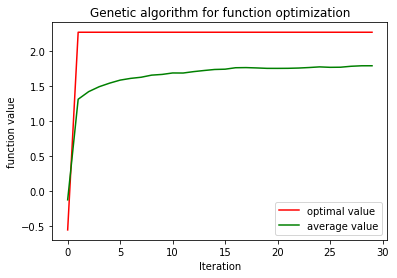

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.984546      0.929005    0.993563   1837064056  2.275783
optimal_weight: [0.98454608 0.92900481 0.99356315]
0:19:30.976519
campaign_id: 1837064050
Generation 0: optimal function value is: -0.549442; average function value is -0.128652
Generation 1: optimal function value is: 2.223724; average function value is 1.317552
Generation 2: optimal function value is: 2.239092; average function value is 1.422185
Generation 3: optimal function value is: 2.239092; average function value is 1.487267
Generation 4: optimal function value is: 2.257032; average function value is 1.526530
Generation 5: optimal function value is: 2.257032; average function value is 1.550184
Generation 6: optimal function value is: 2.257032; average function value is 1.592194
Generation 7: optimal function value is: 2.257032; average function value is 1.610362
Generation 8: optimal function value is: 2.257032; average function value is 1.621456
Generati

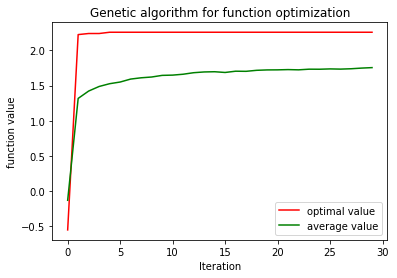

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.987691       0.81357    0.991918   1837064050  2.257032
optimal_weight: [0.98769126 0.81356985 0.99191826]
0:23:42.960609
campaign_id: 1837064053
Generation 0: optimal function value is: -0.534574; average function value is -0.088937
Generation 1: optimal function value is: 2.148571; average function value is 1.277948
Generation 2: optimal function value is: 2.154825; average function value is 1.386225
Generation 3: optimal function value is: 2.154825; average function value is 1.467725
Generation 4: optimal function value is: 2.154825; average function value is 1.517923
Generation 5: optimal function value is: 2.154825; average function value is 1.535522
Generation 6: optimal function value is: 2.159196; average function value is 1.561224
Generation 7: optimal function value is: 2.168783; average function value is 1.584346
Generation 8: optimal function value is: 2.169496; average function value is 1.596634
Generati

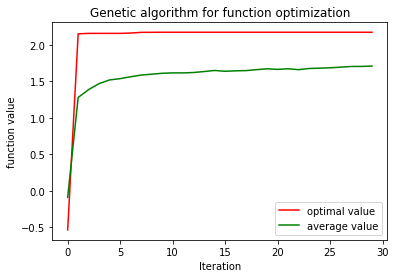

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.997653       0.77605    0.990022   1837064053  2.170348
optimal_weight: [0.99765268 0.77605001 0.990022  ]
0:27:53.601966
campaign_id: 1837064059
Generation 0: optimal function value is: -0.527542; average function value is -0.072488
Generation 1: optimal function value is: 2.116589; average function value is 1.219408
Generation 2: optimal function value is: 2.116589; average function value is 1.294679
Generation 3: optimal function value is: 2.116589; average function value is 1.370240
Generation 4: optimal function value is: 2.116589; average function value is 1.418995
Generation 5: optimal function value is: 2.116589; average function value is 1.447085
Generation 6: optimal function value is: 2.116589; average function value is 1.499864
Generation 7: optimal function value is: 2.116589; average function value is 1.520033
Generation 8: optimal function value is: 2.116589; average function value is 1.536926
Generati

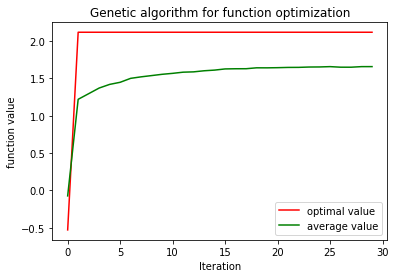

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.995365      0.975305    0.979296   1837064059  2.116589
optimal_weight: [0.995365   0.9753052  0.97929625]
0:31:45.704669
campaign_id: 1896291336
Generation 0: optimal function value is: -0.628396; average function value is -0.268322
Generation 1: optimal function value is: 2.691038; average function value is 1.786457
Generation 2: optimal function value is: 2.691129; average function value is 1.921051
Generation 3: optimal function value is: 2.691129; average function value is 1.948623
Generation 4: optimal function value is: 2.691129; average function value is 1.990174
Generation 5: optimal function value is: 2.691129; average function value is 2.017351
Generation 6: optimal function value is: 2.691129; average function value is 2.026259
Generation 7: optimal function value is: 2.691129; average function value is 2.050426
Generation 8: optimal function value is: 2.691129; average function value is 2.068827
Generati

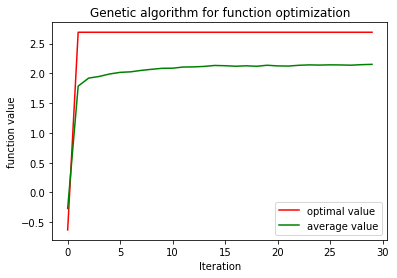

   weight_kpi  weight_spend  weight_bid  campaign_id     score
0    0.667154      0.736179    0.999924   1896291336  2.691129
optimal_weight: [0.66715388 0.73617943 0.99992373]
0:35:36.917728
0:35:36.917768


In [6]:
if __name__ == "__main__":
    starttime = datetime.datetime.now()
    retrive_all_criteria_insights()
    campaign_id_list = gdn_db.get_campaign()['campaign_id'].unique()
    for campaign_id in campaign_id_list:
#         ga_optimal_weight(campaign_id)
        print('campaign_id:', campaign_id )
        global df
        df = ObjectiveFunc().campaign_status(campaign_id)
        bound = np.tile([[0], [1]], vardim)
        ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
        optimal = ga.solve()
        score = ObjectiveFunc.fitnessfunc(optimal, df)

        score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
        df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])

        df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
        df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)
        
        print(df_final)
        gdn_db.check_optimal_weight(campaign_id, df_final)
        for criteria in CRITERIA_LIST:
            get_criteria_score( campaign_id=campaign_id, criteria=criteria )
#         ga_optimal_weight(campaign_id)
        
        print('optimal_weight:', optimal)
        print(datetime.datetime.now()-starttime)    
    print(datetime.datetime.now()-starttime)
    import gc
    gc.collect()    